In [1]:
import os
import sys

sys.path.append("../")

envkey = "OMP_NUM_THREADS"
# Set this environment variable to the number of available cores in your machine,
# to get a fast execution of the Einstein Boltzmann Solver
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))
os.environ[envkey] = str(12)
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))

The value of OMP_NUM_THREADS is:  None
The value of OMP_NUM_THREADS is:  12


In [2]:
import astropy.units as u
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numba
import numpy as np
import seaborn

from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

In [3]:
seaborn.set_theme(rc={'axes.edgecolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black',})
Cp = seaborn.color_palette("Paired")
Cp

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [4]:
seaborn.set_theme(rc={'axes.edgecolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black',})
Cs = seaborn.color_palette("Set2")
Cs

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [5]:
from SSLimPy.cosmology import astro as sastro
from SSLimPy.cosmology import cosmology, halo_model
from SSLimPy.interface import sslimpy
from SSLimPy.interface import survey_specs as sss
from SSLimPy.LIMsurvey import covariance as scov
from SSLimPy.LIMsurvey import higher_order
from SSLimPy.LIMsurvey import power_spectrum as sps
from SSLimPy.LIMsurvey import ingredients_T0
from SSLimPy.utils import fft_log
from SSLimPy.utils.utils import *

In [6]:
cosmo_dict = {
    "h": 0.7,
    "ns": 0.96,
    "sigma8": 0.82,
    "Omegab": 0.05,
    "Omegam": 0.32,
    "mnu": 0.06,
    "Neff": 3.044
}

halo_dict = {
    "hmf_model":"ST",
    "bias_model": "b1",
    "nR" : 256,
    "Rmin": 1e-3 * u.Mpc,
    "Rmax": 1e3 * u.Mpc,
    "bloating": "Mead20",
}

In [7]:
kminebs=1e-5
kmaxebs=50

settings = {"code":"class",
            "do_RSD" : True,
            "nonlinearRSD" : True,
            "FoG_damp" : "ISTF_like",
            "halo_model_PS" : True,
            "Smooth_window" : False,
            "nk":200,
            "kmax": kmaxebs*u.Mpc**-1,
            "kmin": kminebs*u.Mpc**-1,
            "Smooth_resolution": False,
            }

sslimpy.sslimpy(settings_dict=settings)

  █████   █████  █       █            █████   █    █ 
 █     █ █     █ █            █   █   █    █  █   █  
 █       █       █     ███   █ █ █ █  █    █   █ █   
  █████   █████  █       █   █  █  █  █████     █    
       █       █ █       █   █     █  █        █     
 █     █ █     █ █       █   █     █  █       █      
  █████   █████  █████ █████ █     █  █      █       

#---------------------------------------------------#


In [8]:
s_cosmo = cosmology.CosmoFunctions(cosmopars=cosmo_dict)
s_halo = halo_model.HaloModel(s_cosmo, halo_dict)

survey_specs = sss.SurveySpecifications(dict(), s_cosmo)
astro = sastro.AstroFunctions(s_halo, survey_specs)

kgrid = s_halo.k
Pgrid = s_halo.cosmology.matpow(kgrid, 0, tracer="clustering")

In [9]:
kmin = 5e-3*u.Mpc**-1
kmax = 5*u.Mpc**-1
pobs_settings = {"nk":100,
            "kmin": kmin,
            "kmax": kmax,
            "nmu":20
            }

In [10]:
pobs = sps.PowerSpectra(astro, settings=pobs_settings)
cov = scov.nonGuassianCov(pobs)

In [11]:
z = 0
k = pobs.k
Pk = pobs.cosmology.matpow(k, z, nonlinear=False, tracer="clustering")

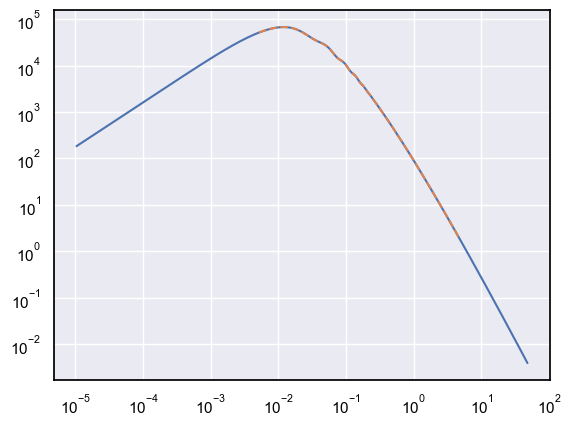

In [12]:
plt.loglog(kgrid, Pgrid)
plt.loglog(k, Pk,"--")

Luminosity weight bias: 1.1095025886357621
log-avraged power-law slope: 0.564917751669066


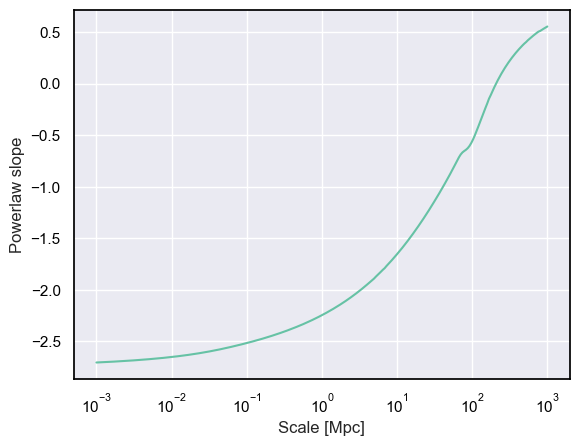

In [13]:
Lmb1 = astro.bavg("b1", z, 1)
print("Luminosity weight bias:", Lmb1)

R = s_halo.R
n_eff = s_halo.n_eff_of_z(R,0,"clustering")
nu = -1/(np.mean(n_eff))

plt.semilogx(R, n_eff, c=Cs[0])
plt.xlabel("Scale [Mpc]")
plt.ylabel("Powerlaw slope")
print("log-avraged power-law slope:", nu)


In [14]:
def extrap_pk(k, kgrid, Pkgrid):
    logk = np.log(k)
    logkgrid = np.log(kgrid)
    logPkgrid = np.log(Pkgrid)
    logPk = linear_interpolate(logkgrid, logPkgrid, logk)
    return np.exp(logPk)

-0.7143007741315454


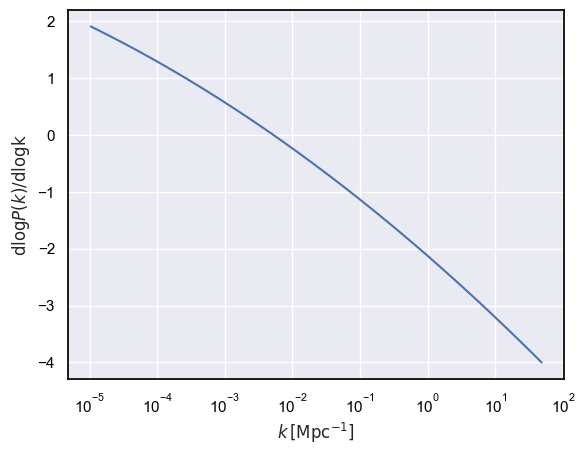

In [15]:
logInter = UnivariateSpline(np.log(kgrid.value), np.log(Pgrid.value))
dlogPdlogk = logInter.derivative(1)(np.log(kgrid.value))
plt.semilogx(kgrid, dlogPdlogk)
plt.xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\mathrm{dlog}P(k)/\mathrm{dlogk}$")
meanslope = np.mean(dlogPdlogk)
print(meanslope)


In [16]:
def p_rec(k, q):
    tf = fft_log.FFTLog(extrap_pk, kminebs,
                              kmaxebs,
                              10, -q, kgrid=kgrid.value, Pkgrid=Pgrid.value)
    return tf(k).real

q, cov = curve_fit(p_rec, k.value, Pk.value, p0=[0.3], sigma=Pk.value)
print(q[0], cov[0])

-1.1403976616844789 [28.55280097]


Powerlaw Decomposition

In [107]:
plaw = fft_log.FFTLog(extrap_pk, kminebs/50, kmaxebs*10, 12, -q[0], kgrid=kgrid.value, Pkgrid=Pgrid.value)
psigma = fft_log.FFTLog(extrap_pk, kminebs/50, kmaxebs*10, 12, nu, kgrid=kgrid.value, Pkgrid=Pgrid.value)
ppow = fft_log.FFTLog(extrap_pk, kminebs/50, kmaxebs*10, 12, -meanslope, kgrid=kgrid.value, Pkgrid=Pgrid.value)

In [108]:
ptrue = s_cosmo.matpow(k, 0.0, tracer="clustering").value
pklaw = plaw(k.value)
pksigma = psigma(k.value)
pkpow = ppow(k.value)

/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


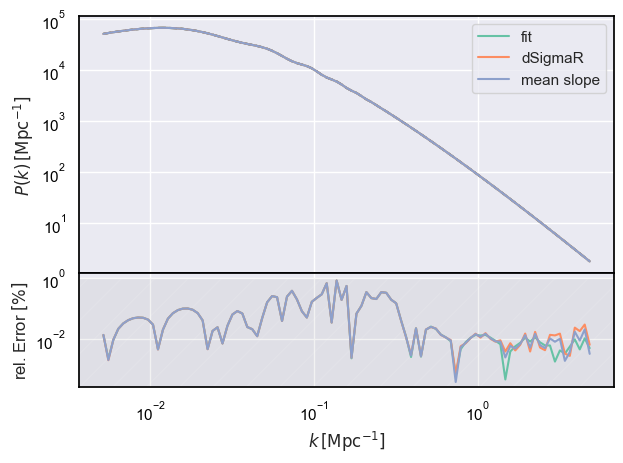

In [109]:
fig, axs = plt.subplots(2, 1, height_ratios=[9,4])

axs[0].loglog(k, ptrue, "k--")
axs[0].loglog(k, pklaw, c=Cs[0],label="fit")
axs[0].loglog(k, pksigma, c=Cs[1],label="dSigmaR")
axs[0].loglog(k, pkpow, c=Cs[2],label="mean slope")
axs[1].axhspan(0, 1, alpha=0.1, hatch="/", fc="grey")
axs[1].loglog(k, np.abs(pklaw/ptrue-1)*100, c=Cs[0])
axs[1].loglog(k, np.abs(pksigma/ptrue-1)*100, c=Cs[1])
axs[1].loglog(k, np.abs(pkpow/ptrue-1)*100, c=Cs[2])
axs[0].legend()
axs[1].set_xlabel(r"$k\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$P(k)\,[\mathrm{Mpc}^{-1}]$")
axs[1].set_ylabel(r"rel. Error $[\%]$")
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)

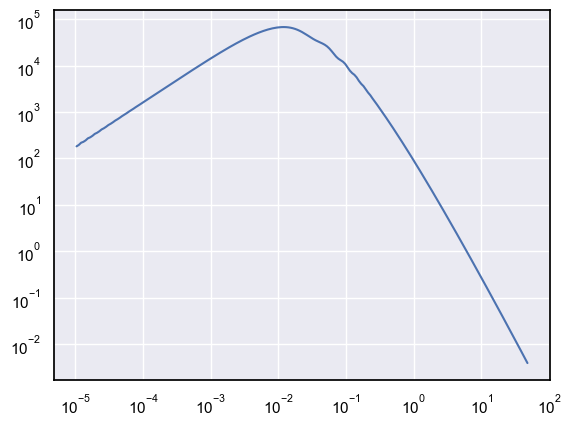

In [110]:
plt.loglog(kgrid, plaw(kgrid.value))

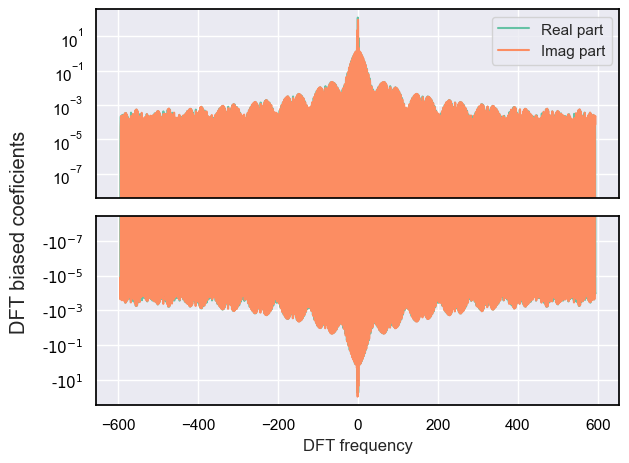

In [111]:
fig, axs = plt.subplots(2,1, sharex=True)

gamma, coef = plaw.get_power_and_coef()
axs[0].semilogy(gamma.imag, coef.real, c=Cs[0], label="Real part")
axs[0].semilogy(gamma.imag, coef.imag, c=Cs[1], label="Imag part")
axs[1].semilogy(gamma.imag, -coef.real, c=Cs[0])
axs[1].semilogy(gamma.imag, -coef.imag, c=Cs[1])
axs[1].invert_yaxis()

axs[1].set_xlabel("DFT frequency")
fig.supylabel("DFT biased coeficients")
axs[0].legend(loc="upper right")
plt.tight_layout()
yticks = axs[1].get_yticks()
new_ytick_labels = ['-$10^{:s}$'.format("{"+str(int(np.log10(tick)))+"}") if tick != 0 else '0' for tick in yticks]
axs[1].set_yticks(yticks[2:-2], new_ytick_labels[2:-2])

In [112]:
TX_MM = Pk[:,None]**2 * Pk[None,:] * ingredients_T0.star(k[:,None], k[None, :], Lmb1, 0, 0, 0, 0, 0, 0)
np.fill_diagonal(TX_MM, Pk**3 * ingredients_T0.star_lim(Lmb1,0,0,0,0,0,0))
TX_MM += TX_MM.T
T_3111_ref = TX_MM * 12

/home/sefa/Desktop/LIM-Code/SSLimPy/notebooks/../SSLimPy/LIMsurvey/ingredients_T0.py:41: RuntimeWarning: divide by zero encountered in log
  * (np.log(np.power((k1 - k2) / (k1 + k2), 2)))
/home/sefa/Desktop/LIM-Code/SSLimPy/notebooks/../SSLimPy/LIMsurvey/ingredients_T0.py:32: RuntimeWarning: invalid value encountered in multiply
  + 3


In [113]:
TSA_MM = np.zeros((*k.shape, *k.shape), dtype=complex)
TSA_MM_diag = np.zeros(*k.shape, dtype=complex)

for gammai, coefi in zip(gamma, coef):
    TSA_MM += coefi * Pk.value[:,None]**2  * ingredients_T0.snake_A(k[:,None], k[None,:], Lmb1, 0., 0., gammai)
    TSA_MM_diag += coefi * Pk.value**2 * ingredients_T0.snake_A_lim(k, Lmb1, 0.0, 0.0, gammai)
np.fill_diagonal(TSA_MM, TSA_MM_diag)

TSA_MM *= 8
TSA_MM += TSA_MM.T

/home/sefa/Desktop/LIM-Code/SSLimPy/notebooks/../SSLimPy/LIMsurvey/ingredients_T0.py:253: RuntimeWarning: invalid value encountered in power
  * np.power(np.abs(k1 - k2), an)


In [114]:
TSX_MM = np.zeros((*k.shape, *k.shape), dtype=complex)
TSX_MM_diag = np.zeros(*k.shape, dtype=complex)

for gammai, coefi in zip(gamma, coef):
    TSX_MM += coefi * Pk.value[:,None] * Pk.value[None, :] * ingredients_T0.snake_X(k[:,None], k[None,:], Lmb1, 0., 0, gammai)
    TSX_MM_diag += coefi * Pk.value**2 * ingredients_T0.snake_X_lim(k, Lmb1, 0.0, 0.0, gammai)
np.fill_diagonal(TSX_MM, TSX_MM_diag)

TSX_MM *= 16

/home/sefa/Desktop/LIM-Code/SSLimPy/notebooks/../SSLimPy/LIMsurvey/ingredients_T0.py:449: RuntimeWarning: invalid value encountered in power
  * np.power(np.abs(k1 - k2), an)


/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(100000.0, 1e+17)

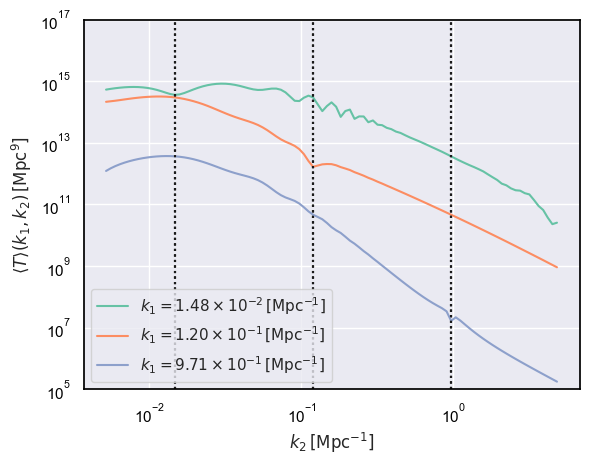

In [115]:
colors=iter(Cs)

T_ref = T_3111_ref.value + TSA_MM + TSX_MM
indicies = [15, 45, 75]
for index in indicies:
    k_val = k.value[index]
    exponent = int(np.floor(np.log10(k_val)))
    mantissa = k_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}\,[\mathrm{{Mpc}}^{{-1}}]$"    
    plt.loglog(k, T_ref[:, index], label=label, c=next(colors))
    plt.vlines([k.value[index] for index in indicies], 1e5, 1e17, "k", ":")

plt.xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$\langle T \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
plt.legend()
plt.ylim(1e5, 1e17)

In [116]:
k.min(), kgrid.min()

(<Quantity 0.00518067 1 / Mpc>, <Quantity 1.04029776e-05 1 / Mpc>)

In [117]:
@numba.njit("(float64, float64, float64, float64[::1], float64[::1], uint32)")
def partial_Tcollapsed(chi, k1, k2, kgrid, Pkgrid, alpha):
    mu = (2 * chi**alpha - 1)
    f = higher_order.collapsed_Trispectrum_LO(Lmb1, 0, 0, 0, 0, 0.0, 0.0, 0.0, k1, 1.0, 0.0, k2, mu, 0.0, kgrid, Pkgrid)
    jac = 2 * alpha * chi**(alpha - 1)
    return jac * f

@numba.njit("float64[::1], float64[::1], float64[::1], uint32", parallel=True)
def Tmean(k, kgrid, Pkgrid, alpha):
    kl = len(k)
    T = np.zeros((kl, kl))
    for ik1 in numba.prange(kl):
        for ik2 in range(ik1, kl):
            T[ik1, ik2] = adaptive_mesh_integral(0, 1, partial_Tcollapsed, (k[ik1], k[ik2], kgrid, Pkgrid, alpha),
                                                 eps=1e-2, jmin=5, jmax=20)
    return T + T.T

In [67]:
T = Tmean(k.value, kgrid.value, Pgrid.value, 3)

In [34]:
from scipy.special import roots_legendre

In [35]:
n_Num = 400
xi, wi = roots_legendre(n_Num)
X_SL = np.empty((*k.shape, *k.shape, n_Num))

for ik1, k1i in enumerate(k):
    for ik2, k2i in enumerate(k):
        for imu, mui in enumerate(xi):

            # Compute over all permutations of the 1113 diagrams
            X_SL[ik1, ik2, imu] = higher_order.vF3(k1i.value, 1.0, 0.0, k1i.value, -1.0, np.pi, k2i.value, xi[imu], 0.0)
X_SL = 12 * np.sum(X_SL * wi, axis=-1) / 2 * Lmb1**4

In [36]:
T_3111_SL = X_SL * Pk[:, None]**2 * Pk[None, :]
T_3111_SL += T_3111_SL.T


/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/astropy/units/quantity.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self.to_value(dimensionless_unscaled))


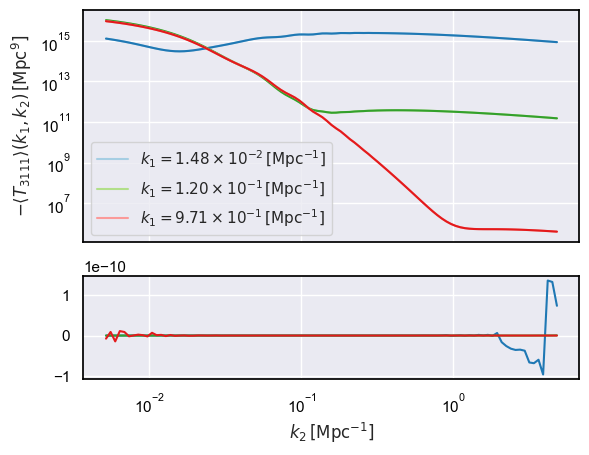

In [37]:
indicies = [15, 45, 75]

fig, axs = plt.subplots(2,1, sharex=True, height_ratios=[9,4])
colors = iter(Cp)

for index in indicies:
    k_val = k.value[index]
    exponent = int(np.floor(np.log10(k_val)))
    mantissa = k_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}\,[\mathrm{{Mpc}}^{{-1}}]$"
    axs[0].loglog(k, -T_3111_SL[:, index], label=label, c=next(colors))
    c= next(colors)
    axs[0].loglog(k, -T_3111_ref[:, index], ls="-", c= c)
    axs[1].semilogx(k, T_3111_ref[:, index]/T_3111_SL[:, index]-1, c=c)


# plt.vlines([k.value[index] for index in indicies], 0, 1e15, "k", ":")

axs[1].set_xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$-\langle T_{3111} \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
axs[0].legend()

In [38]:
n_Num = 400
xi, wi = roots_legendre(n_Num)
X_SL = np.empty((*k.shape, *k.shape, n_Num))

for ik1, k1i in enumerate(k):
    for ik2, k2i in enumerate(k):
        for imu, mui in enumerate(xi):
            k12, mu12, ph12 = addVectors(k1i.value, 1, 0.0, k2i.value, mui, 0.0)
            Z2_1 = higher_order.vZ2(Lmb1, 0., 0., 0., k1i.value, -1, np.pi, k12, mu12, ph12)
            logk12 = np.log(np.array([k12]))
            logPk12 = linear_interpolate(np.log(kgrid.value), np.log(Pgrid.value), logk12)[0]
            X_SL[ik1, ik2, imu] = 8 * Z2_1**2 *Lmb1**2 * np.exp(logPk12) * Pk.value[ik1]**2
X_SL += np.transpose(X_SL,(1,0,2))

T_2111_SL_A = np.sum(X_SL * wi, axis=-1)/2

/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


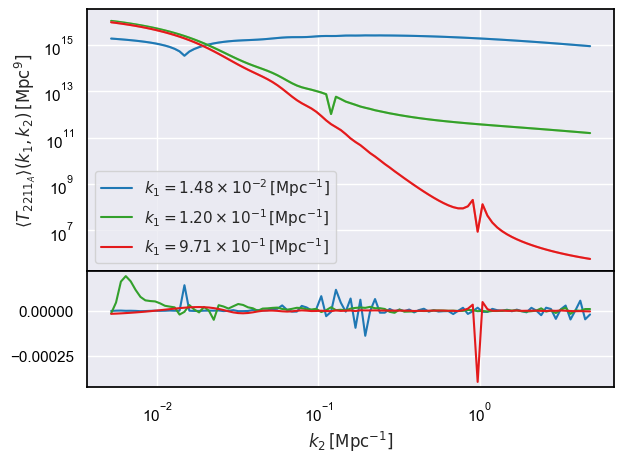

In [39]:
fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[9,4])

indicies = [15, 45, 75]

colors = iter(Cp)

for index in indicies:
    k_val = k.value[index]
    exponent = int(np.floor(np.log10(k_val)))
    mantissa = k_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}\,[\mathrm{{Mpc}}^{{-1}}]$"
    axs[0].loglog(k, TSA_MM[:, index], ls="-", c= next(colors))
    c = next(colors)
    axs[0].loglog(k, T_2111_SL_A[:, index], label=label, c=c)
    axs[1].semilogx(k, TSA_MM[:, index]/T_2111_SL_A[:, index]-1, c=c)
# plt.vlines([k.value[index] for index in indicies], 0, 1e15, "k", ":")

axs[1].set_xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$\langle T_{2211_A} \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
axs[0].legend()
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)

In [124]:
n_Num = 400
xi, wi = roots_legendre(n_Num)
X_SL = np.empty((*k.shape, *k.shape, n_Num))

for ik1, k1i in enumerate(k):
    for ik2, k2i in enumerate(k):
        for imu, mui in enumerate(xi):
            k12, mu12, ph12 = addVectors(k1i.value, 1, 0.0, k2i.value, mui, 0.0)
            Z2_1 = higher_order.vZ2(Lmb1, 0., 0., 0., k1i.value, -1,   np.pi, k12, mu12, ph12)
            Z2_2 = higher_order.vZ2(Lmb1, 0., 0., 0., k2i.value, -mui, np.pi, k12, mu12, ph12)

            logk12 = np.log(np.array([k12]))
            logPk12 = linear_interpolate(np.log(kgrid.value), np.log(Pgrid.value), logk12)[0]
            X_SL[ik1, ik2, imu] = (
                16 * Z2_1 * Z2_2 *Lmb1**2
                * np.exp(logPk12) * Pk.value[ik1] * Pk.value[ik2]
            )

T_2111_SL_X = np.sum(X_SL * wi, axis=-1)/2

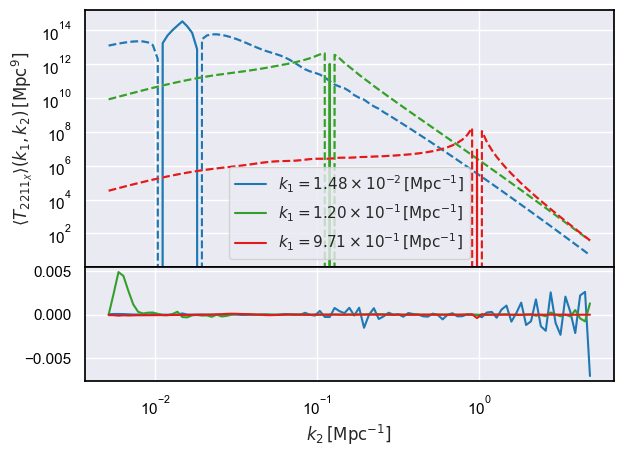

In [42]:
fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[9,4])

indicies = [15, 45, 75]

colors = iter(Cp)

for index in indicies:
    k_val = k.value[index]
    exponent = int(np.floor(np.log10(k_val)))
    mantissa = k_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}\,[\mathrm{{Mpc}}^{{-1}}]$"

    c = next(colors)
    axs[0].loglog(k, TSX_MM[:, index], ls="-", c= c)
    axs[0].loglog(k, -TSX_MM[:, index], ls="--", c= c)
    c = next(colors)
    axs[0].loglog(k, T_2111_SL_X[:, index], label=label, c=c)
    axs[0].loglog(k, -T_2111_SL_X[:, index], ls="--", c=c)
    axs[1].semilogx(k, TSX_MM[:, index]/T_2111_SL_X[:, index]-1, c=c)
# plt.vlines([k.value[index] for index in indicies], 0, 1e15, "k", ":")

axs[1].set_xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$\langle T_{2211_X} \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
axs[0].legend()
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)

In [119]:
T_DI = T_3111_SL.value + T_2111_SL_A + T_2111_SL_X
T_MM = T_3111_ref.value + TSA_MM + TSX_MM

In [123]:
T_DI[:,15]

array([5.33319409e+14, 5.63964608e+14, 5.91803240e+14, 6.15624269e+14,
       6.34180358e+14, 6.46170570e+14, 6.50285196e+14, 6.45244999e+14,
       6.30127885e+14, 6.04494053e+14, 5.68599893e+14, 5.23936845e+14,
       4.73670884e+14, 4.23291549e+14, 3.81463167e+14, 3.60816259e+14,
       3.73221682e+14, 4.13299354e+14, 4.71612510e+14, 5.39924121e+14,
       6.11171925e+14, 6.79365403e+14, 7.39410964e+14, 7.87079454e+14,
       8.18976866e+14, 8.32705445e+14, 8.27091554e+14, 8.02512169e+14,
       7.60996527e+14, 7.06844757e+14, 6.46358790e+14, 5.88294716e+14,
       5.43156914e+14, 5.20143925e+14, 5.24218388e+14, 5.48826974e+14,
       5.74688712e+14, 5.75539700e+14, 5.28771312e+14, 4.33814766e+14,
       3.17661116e+14, 2.31410254e+14, 2.26525090e+14, 2.90922379e+14,
       3.39797620e+14, 2.96893546e+14, 1.77801308e+14, 1.06839622e+14,
       1.55920863e+14, 2.05477466e+14, 1.48342462e+14, 6.94571553e+13,
       1.07458229e+14, 1.19871006e+14, 5.98652256e+13, 7.19491783e+13,
      

/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sefa/Desktop/LIM-Code/SSC-project/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


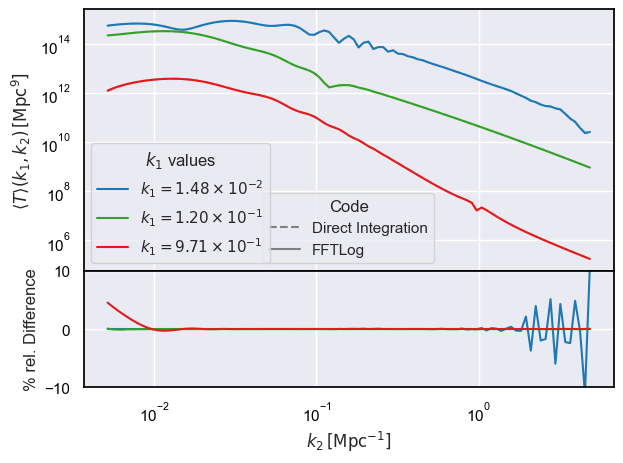

In [120]:
colors = iter(Cp)

fig, axs = plt.subplots(2,1, sharex=True, height_ratios=[9,4])

for index in indicies:
    axs[0].loglog(k, T_DI[:,index], c=next(colors), ls="--")
    c = next(colors)
    axs[0].loglog(k, T_MM[:,index], c=c, ls="-")
    axs[1].semilogx(k, (T_MM[:,index]/T_DI[:,index])*100 - 100, c=c )


# ---------- Legend for line styles ----------
linear_line = mlines.Line2D([], [], color='gray', linestyle='--', label='Direct Integration')
nonlinear_line = mlines.Line2D([], [], color='gray', linestyle='-', label='FFTLog')
legend1 = axs[0].legend(handles=[linear_line, nonlinear_line], loc='lower center', title="Code")
axs[0].add_artist(legend1)  # add manually so it's not overwritten

# ---------- Legend for colors (k1 values) ----------
color_labels = []
for i in indicies:
    k1_val = k.value[i]
    exponent = int(np.floor(np.log10(k1_val)))
    mantissa = k1_val / 10**exponent
    label = fr"$k_1={mantissa:.2f} \times 10^{{{exponent}}}$"
    color_labels.append(label)

# Create legend handles with correct colors (every second color if using next(colors) twice)
color_handles = [
    mlines.Line2D([], [], color=Cp[i*2 +1], linestyle='-', label=label)
    for i, label in enumerate(color_labels)
]

axs[0].legend(handles=color_handles, loc='lower left', title=r"$k_1$ values")

plt.xlabel(r"$k_2\,[\mathrm{Mpc}^{-1}]$")
axs[0].set_ylabel(r"$\langle T \rangle(k_1,k_2)\,[\mathrm{Mpc}^{9}]$")
axs[1].set_ylabel(r"% rel. Difference")
axs[1].set_ylim(-10,10)
plt.grid(True)
plt.tight_layout()
fig.subplots_adjust(hspace=0.0)
plt.savefig("T4h_SSLimpy_v_pyCCL.pdf")
plt.show()